# MPModel: Infering the detergent corona around a membrane protein

Throughout this tutorial, we will buid a coarse-grained model of a micelle around the  membrane protein Aquaporin-0 (PDB: 2B6P [1]) and use the `simSPI` package to simulate a cryo-EM experiment of the structure. For that, it is necessary to have installed the TEM-simulator [2] and the python libraries: Matplotlib Numpy, Gemmi, Scikit-learn and Scipy.


<p align="center">
    <img src="figures/2b6p_map.png" alt="Drawing" style="width: 700px;"/>
    <p style="text-align: center">
        Figure 1: _Bos taurus_ Aquaporin-0 complex
    </p>
</p>


[1] https://www.rcsb.org/structure/2B6P

[2] http://tem-simulator.sourceforge.net/

In [ ]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

In [37]:
import numpy as np
import math
import gemmi
import torch
import mrcfile
from matplotlib import pyplot as plt, axes as ax
from scipy.spatial.transform import Rotation as rot

from simSPI.linear_simulator.linear_simulator import LinearSimulator
from test_linear_simulator import init_data

print(sys.path)
from simSPI.mpmodel import detergent_belt
#from simSPI.mpmodel import atomic_models

['/home/halv/compSPI_fork/simSPI/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/halv/.local/lib/python3.8/site-packages', '/home/halv/simSPI', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/halv/compSPI_fork/simSPI']


ModuleNotFoundError: No module named 'simSPI.mpmodel'

## Creating the model
### Extracting the protein atomic coordinates from a PDB file

In [3]:
aqp = mpm.MembraneProtein("2b6p.pdb") #path to pdb file

<p align="center">
    <img src="figures/aquaporin.png" alt="Drawing" style="width: 400px;"/>
    <p style="text-align: center">
        Figure 2: Representation of the atomic coordinates of aquaporin
    </p>
</p>

### Centering and rotating the structure
<p style='text-align: justify;margin-right:10%;'>
Using Principal Component Analysis (PCA), a method for data decomposition, we can extract the main axis where our data is distributed. We can use a matrix transformation as a function to represent a modification on our dataset. In this case, the transformation is aligning the principal component of the coordinate points to the Z-axis. Therefore, we can distribute the atoms on another axis and, by doing so, rotate the protein so that its transmembrane portion is positioned properly in space.
</p>

In [7]:
aqp.rotate_protein(axis='X')

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 73.7 ms


<p align="center">
    <img src="figures/aquaporin_rotated.png" alt="Drawing" style="width: 400px;"/>
    <p style="text-align: center">
        Figure 3: Aquaporin structure rotated and centered at the origin
    </p>
</p>

***
### Creating a corona around the protein

To create the Ellipsoid we will compute the points that satisfy the condition: 
$\frac{x^{2}}{a^{2}} + \frac{y^{2}}{b^{2}} + \frac{z^{2}}{c^{2}} >= 1$

Consider $O = (0,0,0)$, as the protein was centered after the coordinates were imported.

<p align="center">
    <img src="figures/ellipsoid.png" alt="Drawing" style="width: 200px;"/>
    <p style="text-align: center">
        Figure 4: The geometric parameters of an ellipsoid
    </p>
</p>

The method used in this program creates an ellipsoid by generating points iteratively in regular intervals dependent on the ray of the pseudoatom. After that, a function removes the coordinates in the most inner part of the ellipsoid that would conflict with the protein's atoms. This process' speed depends on the number of pseudo atoms, that itself depends on the parameters of the corona such as the height, determined by size of the transmembrane portion of the protein, and on the ray of the pseudo atoms filling the ellipsoid.

Let us create the hydrophobic interior ellipsoid of the corona with parameters chosen empirically for a better visualization of the exemple on Pymol.</br>

major axis &rarr; 35Å</br>
minor axis &rarr; 25Å</br>
ellipticity &rarr; 2</br>
pseudo atom type &rarr; CA</br>
pseudo atom ray &rarr; 1.5</br>

major axis &rarr; 40Å</br>
minor axis &rarr; 30Å</br>
ellipticity &rarr; 2</br>
pseudo atom type &rarr; N</br>
pseudo atom ray &rarr; 1.5

In [11]:
C = mpm.BeltCore()
C.set_belt_parameters(35, 25, 2)    #set the parameters for the core of your micelle
C.set_atomic_parameters(1.5, "CA")  #set the parameters for you hydrophilic pseudoatom
C.generate_ellipsoid()

S = mpm.BeltShell()
S.set_belt_parameters(40, 30, 2)    #set the parameters for the shell of your micelle
S.set_atomic_parameters(1.5, "N")   #set the parameters for you hydrophobic pseudoatom
S.generate_ellipsoid()

CPU times: user 8.44 ms, sys: 0 ns, total: 8.44 ms
Wall time: 7.47 ms


### Excluding the overlaping pseudoatoms
Now that we have our two ellipsoids we need to delete from our corona the pseudo atoms that are physically overlapping with other atoms
Observation: the next steps take a couple of minutes to run

In [12]:
C.in_hull(aqp.final_coordinates)
C.remove()
 
S.in_hull(C.coordinates_set)
S.remove()
S.in_hull(aqp.final_coordinates)      
S.remove()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.58 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


### Generating the final PDB file

In [13]:
file_name = "outputs/my_model.pdb"   #name your pdb file
M = mpm.Model()
M.clean_gemmi_structure()
M.write_atomic_model(file_name, model=gemmi.Model("model"))
M.create_model(file_name,C,S,aqp)

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 17.6 µs


<p align="center">
    <img src="figures/aqp_model_abc.png" alt="Drawing" style="width: 600px;"/>
    <p style="text-align: center">
        Figure 5: Model of detergent micelle and membrane protein Aquaporin (AQP0) seen as A- full model, B- micelle
hydrophobic core and C- frontal cut. The micelle hydrophobic core is represented in yellow,
the hydrophilic shell in blue and the protein in pink.
    </p>
</p>

XXXXXXXXXXXXX CHIMERAX XXXXXXXXXXXXX molmap #[structure] [res]

ADD STEPS
ADD IMAGE
MAYBE AUTOMIZE

## Linear Simulation

In [7]:
def rotation(N):
    A = np.random.uniform(0,2*np.pi,N)
    V = np.random.uniform(0,1,3)
    R = []
    for a in A:
        r = rot.from_rotvec(a*V)
        R.append(r.as_matrix())
    return R #sampled rotations

In [8]:
def LinSim(vol_path, data_path, rotations):
    '''
    rotations -> list of rotation matrices
    '''
    with mrcfile.open(vol_path) as file:
        vol = file.data
    saved_data, config = init_data(data_path)
    
    #nx = vol.shape[0]
    nx = 200
    config["input_volume_path"] = vol_path
    config["side_len"] = nx
    config["ctf_size"] = nx
    config["pixel_size"] = 1.2
    
    config["noise"] = True
    config["noise_sigma"] = 1

    lin_sim = LinearSimulator(config)
    
    N = len(rotations)
    
    ctf_params = saved_data["ctf_params"]
    shift_params = saved_data["shift_params"]
    rot_params = {'rotmat': torch.Tensor(rotations)}
    
    #ctf_params["defocus_u"] = torch.tensor([1,2,3,4,5]).reshape(N,1,1,1)
    #ctf_params["defocus_v"] = torch.tensor([1,2,3,4,5]).reshape(N,1,1,1)
    #ctf_params["defocus_angle"] = torch.tensor([1,2,3,4,5]).reshape(N,1,1,1)
    #shift_params["shift_x"] = torch.tensor([1,2,3,4,5])
    #shift_params["shift_y"] = torch.tensor([1,2,3,4,5])
    
    particles = lin_sim(rot_params, ctf_params, shift_params)
    
    return particles #torch tensor for particle projection

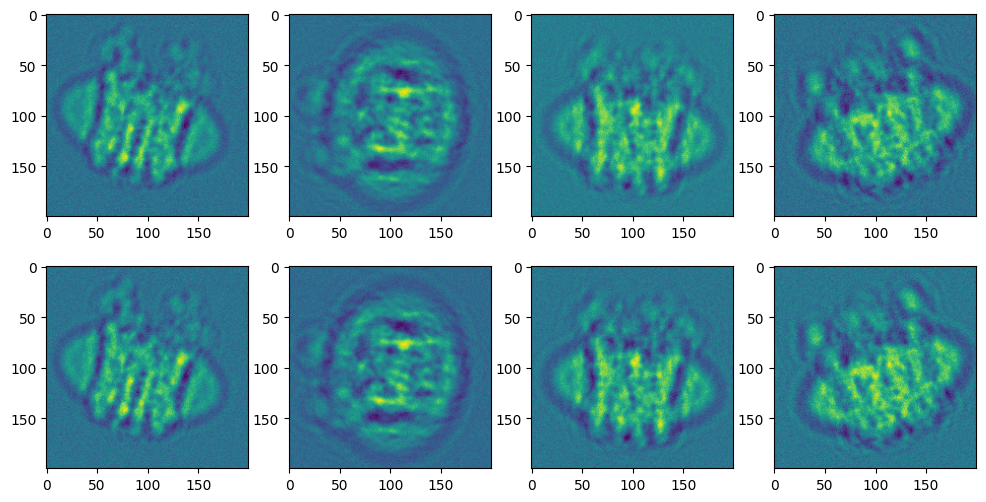

In [17]:
root_dir = "/home/halv/"  # change this to your simSPI directory.
vol_path = f"{root_dir}MembraneProteins/output/mrc/toy_model_50.mrc"
data_path = f"{root_dir}compSPI_fork/simSPI/tests/data/linear_simulator_data.npy"

proj = LinSim(vol_path, data_path, rotation(8))

f, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0,0].imshow(proj[0, 0])
ax[0,1].imshow(proj[1, 0])
ax[0,2].imshow(proj[2, 0])
ax[0,3].imshow(proj[3, 0])
ax[1,0].imshow(proj[4, 0])
ax[1,1].imshow(proj[5, 0])
ax[1,2].imshow(proj[6, 0])
ax[1,3].imshow(proj[7, 0])

## Parameter Inference

<p align="center">
    <img src="figures/parameters_new.png" alt="Drawing" style="width: 450px;"/>
    <p style="text-align: center">
        Figure 6: XXXXXXXXXXXXXXXXXXXXXXX ADD DESCRIPTION AND REFERENCE XXXXXXXXXXXXXXXXXXXX
    </p>
</p>

We will infer the parameter "a" by Rejection Approximation Bayesian Computation.

In [22]:
class ABC():
    '''
    e epsilon rejection criterion
    obs image vector of ground truth
    sim image vector of simulated model
    '''
    def l2(self, proj1, proj2):
        norm = []
        for i in range(len(proj1)):
            norm.append(torch.sum((proj1[i]-proj2[i])**2))
            rank = sorted(norm)
        return rank #np.mean(norm)

    def criterion(self, proj1, proj2):
        e = ((self.criterion*10000) + 40000)   #normalized criterion
        if l2(proj1,proj2) <= e:
            return True
            
    def generate_model():
        pass

    def runABC(self):
        samples = self.samples
        a = np.random.uniform()   #sample parameter a
        model = generate_model()  #create model using sampled a
        self.accepted = []
        for i in range(samples):   
            sim_proj = LinSim(vol_path, data_path, rot) #simulate image with generated model x100
            #superimpose images
            if criterion(obs_proj, sim_proj):
                self.accepted.append(a)   #save parameter

        self.result = np.mean(self.accepted)
        self.rank = sorted(self.accepted)

In [16]:
root_dir = "/home/halv/"  # change this to your simSPI directory.
vol_path1 = f"{root_dir}MembraneProteins/output/mrc/toy_model_50.mrc"
vol_path2 = f"{root_dir}MembraneProteins/output/mrc/toy_model_75.mrc"
data_path = f"{root_dir}compSPI_fork/simSPI/tests/data/linear_simulator_data.npy"

In [17]:
R = rotation(4)

proj1 = LinSim(vol_path1, data_path, R)
proj2 = LinSim(vol_path2, data_path, R)
    
distance = l2(proj1, proj2)

print(distance)

[tensor(56071.7734), tensor(77059.8516), tensor(86262.7969), tensor(101159.0938)]


In [ ]:
gt =  #ground truth

x = ABC()
x.criterion = 0.3
x.iterations = 100
